In [1]:
import cv2
import numpy as np
np.set_printoptions(formatter={'float': '{: 0.4f}'.format})

import matplotlib.pyplot as plt
from bs_img.bs_img_real import *

In [2]:
from bs_cfg_real_5m import *

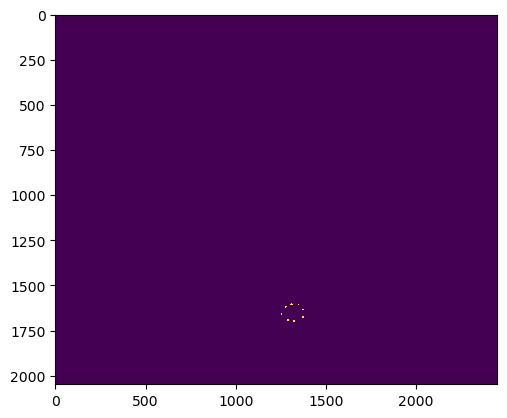

In [7]:
img_name_01 = "Pic_1"
img_color_01 = cv2.imread(f"{img_name_01}.jpg")
img_gray = cv2.cvtColor(img_color_01,cv2.COLOR_RGB2GRAY)
_, img_bin = cv2.threshold(img_gray, 50, 0xff, cv2.THRESH_BINARY)
plt.imshow(img_bin)

In [8]:
gt_pts_01,_ = img_to_pts(img_bin)

In [9]:
def least_square_circe(pts):
    X = pts[:,0]
    Y = pts[:,1]
    A = np.vstack([X,Y,np.ones_like(X)]).T
    B = X*X + Y*Y
    m_vec = np.linalg.pinv(A).dot(B)/2
    cx,cy,m3 = m_vec
    r = np.sqrt(cx*cx + cy*cy + 2*m3)
    return cx,cy,r

    
pts = np.array([
    [0,1],
    [0,-1],
    [1,0],
    [-1,0],
])
least_square_circe(pts)

(0.0, 0.0, 1.0)

In [11]:
def solve_taper(taper_px_ptL,cam_K,taper_radius):
    result_dict = {
        "avaiabel_pt_num": 0,
        "t_vec": np.array([np.nan]*3),
        "img_valid": False,
    }

    pt_num = len(taper_px_ptL)
    # 特征点不足以解算
    if pt_num < 4:
        return result_dict
    taper_px_pts = np.array(taper_px_ptL)
    data_dictL = []
    # 拟合圆并按照在圆上的最大点数和重投影误差排序
    for pts in itertools.combinations(taper_px_ptL,4):
        cx,cy,r = least_square_circe(np.array(pts))
        circle_center = np.array([cx,cy])
        rpes = np.sqrt(np.abs(np.sum((taper_px_pts-circle_center)*(taper_px_pts-circle_center),axis=1) - r*r))
        avaiabel_pt_num = np.sum(rpes<30)
        rpe = np.average(rpes[rpes<30])
        
        # 均为降序则取负
        data_dict = {
            "avaiabel_pt_num": avaiabel_pt_num,
            "rpe": -rpe,
            "cx":cx,
            "cy":cy,
            "r":r,
        }
        data_dictL.append(data_dict)
        
    # 取重投影误差最小的
    data_dictL_dorted = sorted(data_dictL,key=lambda x: [x["avaiabel_pt_num"],x["rpe"]],reverse=True)
    data_dict = data_dictL_dorted[0]

    # 重投影误差过大
    if data_dict["avaiabel_pt_num"] > 4:
        result_dict = data_dict
        depth = taper_radius*cam_K[0][0]/result_dict["r"]
        t_vec = depth*np.linalg.inv(cam_K).dot(np.array([result_dict["cx"],result_dict["cy"],1]))
        result_dict["t_vec"] = t_vec
        result_dict["img_valid"] = True
    return result_dict
result_dict = solve_taper(gt_pts_01,camK_sf,0.4)
result_dict



{'avaiabel_pt_num': 7,
 'rpe': -12.828784508158675,
 'cx': 1325.0994280730374,
 'cy': 1655.161907001404,
 'r': 52.988807909963896,
 't_vec': array([ 0.7819,  4.6692,  53.6607]),
 'img_valid': True}

In [12]:
taper_px_ptL = gt_pts_01
taper_px_ptL

[array([ 1309.1397,  1606.5882]),
 array([ 1345.9512,  1606.1463]),
 array([ 1277.8312,  1620.5195]),
 array([ 1373.3898,  1634.5593]),
 array([ 1254.4537,  1661.2963]),
 array([ 1372.6033,  1679.3058]),
 array([ 1288.7083,  1693.5500]),
 array([ 1323.5635,  1699.1667])]

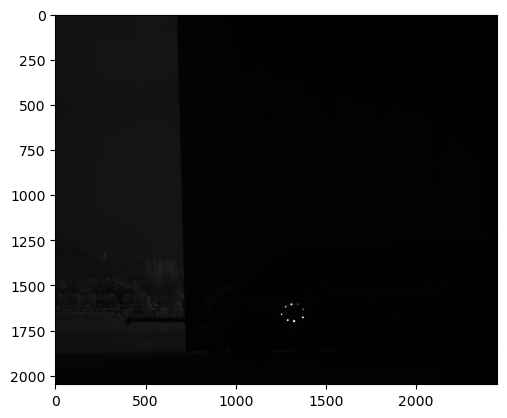

In [13]:
plt.imshow(img_color_01[:,:,::-1])

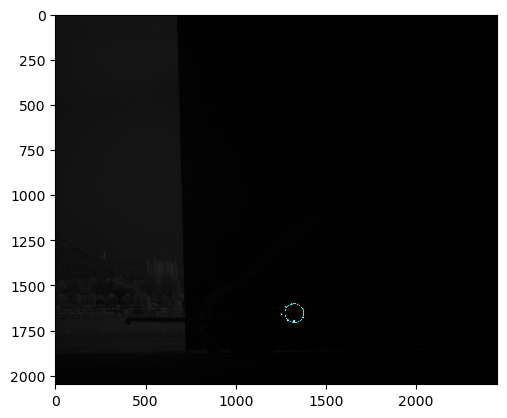

In [14]:
img_result = img_color_01.copy()
taper_cx = result_dict["cx"]
taper_cy = result_dict["cy"]
taper_radius = result_dict["r"]
cv2.circle(img_result, (int(taper_cx), int(taper_cy)), int(taper_radius), (0xff,0xff,0),2)
plt.imshow(img_result[:,:,::-1])

array([-0.4927, -0.3877,  17.3512])

17.351208397201585